In [1]:
import numpy as np
from scipy.interpolate import griddata
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt

import time

## Instructions on using Keras

Models in Keras are defined as a sequence of layers.

We create a [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) object which holds multiple layers executed one by one, and add layers to the object until we have formed the architecture.

To create the first layer, you need to know the right number of input features. You can specify this by using the `input_dim` argument.

The things to choose when defining the architecture are many:
 - number of layers
 - type of layers
 - size of layers
 - type of non-linearity
 - whether or not to add regularization

Here we will use only fully-connected (dense) layers, so the type of layer is fixed. Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class, which takes as parameters the number of neurons (which is the **dimension of the output**).

The activation functions are used after each dense layer. You can choose the activation functions for hidden layers yourself, a common choice being the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation. But for the last layer, the activation must reflect the range of the outputs.

Since we will work with binary classification problem, the output should be between 0 and 1, which is then easy to map to any given class. To ensure this we can use the [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) activation.


After having created a model you need to **compile** it. During the compilation phase you must specify some parameters related to how the model will be optimized:
 - The `optimizer`. For the following exercise you should use [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), initialized with some learning rate (instructions on how to choose it follow).
 - The `loss` function. For binary classification you can use the [cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss.
 - A list of `metrics`: common error functions which you want keras to report at each training epoch.

Then you may actually train the model by calling **fit**. The fit function takes as input the training data, and some more parameters related to the training process:
 - `epochs` : the number of epochs to train for
 - `batch_size` : the size of mini-batches. A high batch-size will speed up computations but may make training unstable.

Other useful functions are `model.predict` which runs the model's forward pass to predict on new samples, and `model.evaluate` which is similar to `predict` but instead of giving predictions as output, it simply computes some metrics.

In [2]:
def generate_2d_cls_data(n, sigma_noise):
    n_cls = n // 2

    theta = np.random.randn(n_cls) * 2 * np.pi
    cls1 = np.stack([np.cos(theta) * 2, np.sin(theta) * 2], axis=1)
    cls2 = np.random.randn(n_cls, 2) * 0.5

    cls1 += np.random.randn(cls1.shape[0], 2) * sigma_noise * 3
    cls2 += np.random.randn(cls2.shape[0], 2) * sigma_noise

    X = np.concatenate([cls1, cls2], axis=0)
    y = np.concatenate([np.zeros(n_cls), np.ones(n_cls)], axis=0)

    return X, y

In [3]:
def separatingFLR(data, labels, predictions, model):
    fig, ax = plt.subplots()

    num_grid_points = 100
    xi = np.linspace(data[:, 0].min(), data[:, 0].max(), num_grid_points)
    yi = np.linspace(data[:, 1].min(), data[:, 1].max(), num_grid_points)
    gdata = np.stack([xi, yi], 1)
    X, Y = np.meshgrid(xi,yi)
    pred_grid = model.predict(
        np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    ).reshape(num_grid_points, num_grid_points)

    ax.contour(xi, yi, pred_grid, 15, linewidths=2, colors='k', levels=[0.5])
    # plot data points.
    ax.scatter(data[:,0], data[:,1], c=labels.ravel(), marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(data[:,0].min(), data[:,0].max())
    ax.set_ylim(data[:,1].min(), data[:,1].max())
    return fig, ax

In [4]:
def calc_err(predicted, observed):
    predicted = predicted.ravel()
    observed = observed.ravel()
    threshold_preds = predicted.copy()
    threshold_preds[predicted < 0.5] = 0
    threshold_preds[predicted >= 0.5] = 1
    return np.mean(threshold_preds != observed)

### Synthetic Example

#### Generating the train and test sets

Note that with neural nets, the labels for binary classification should be 0 and +1.

In [5]:
# put your code here
Xtr, Ytr = generate_2d_cls_data(500, 0.5)
Xte, Yte = generate_2d_cls_data(200, 0.5)

In [6]:
# Build your first model by creating a Sequential object and then adding 2 Dense layers:
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
40/40 [==============================] - 1s 7ms/step - loss: 0.6646 - accuracy: 0.4700 - val_loss: 0.8722 - val_accuracy: 0.0500
Epoch 2/600
40/40 [==============================] - 0s 3ms/step - loss: 0.6120 - accuracy: 0.5725 - val_loss: 0.8922 - val_accuracy: 0.0000e+00
Epoch 3/600
40/40 [==============================] - 0s 3ms/step - loss: 0.5911 - accuracy: 0.6250 - val_loss: 0.8903 - val_accuracy: 0.0000e+00
Epoch 4/600
40/40 [==============================] - 0s 3ms/step - loss: 0.5727 - accuracy: 0.6250 - val_loss: 0.8822 - val_accuracy: 0.0000e+00
Epoch 5/600
40/40 [==============================] - 0s 3ms/step - loss: 0.5540 - accuracy: 0.6550 - val_loss: 0.8694 - val_accuracy: 0.1100
Epoch 6/600
40/40 [==============================] - 0s 3ms/step - loss: 0.5344 - accuracy: 0.6725 - val_loss: 0.8544 - val_accuracy: 0.2200
Epoch 7/600
40/40 [==============================] - 0s 4ms/step - loss: 0.5151 - accuracy: 0.7025 - val_loss: 0.8396 - val_accuracy: 0.2900
E

#### Plot the results from the model

In [7]:
# With this function you can plot the history of the model training produced by the fit function
def plot_history(history):
    fig, ax = plt.subplots()
    # Plot training & validation accuracy values
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Val')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    return fig, ax

313/313 [==============================] - 0s 1ms/step


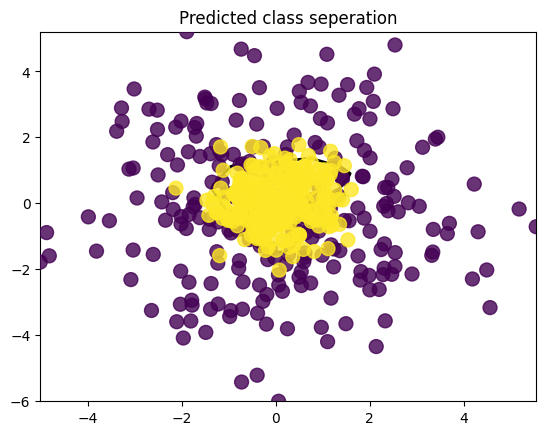

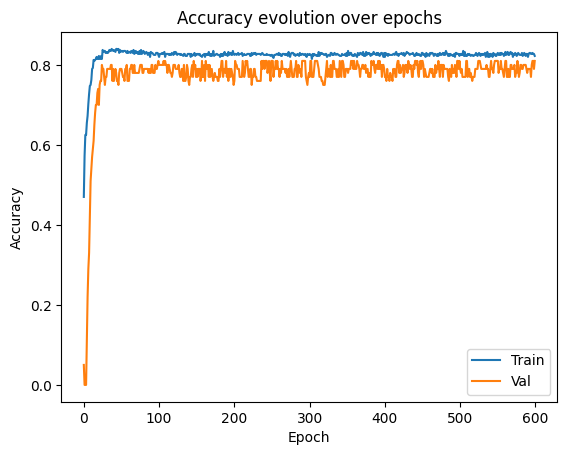

In [8]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

## Exploring Different Architectures

Using a simple binary classification dataset you will build a keras model with Dense layers, and the RELU activation function.

You will explore different architectures to try and see when the NN overfits or underfits the data.

In particular, you should try the following:
 1. A NN with a single hidden layer with many (e.g. 100) neurons
 2. A NN with many (e.g. 3, 4, 5) hidden layers with a few neurons (e.g. 10 to 30).

Train the neural network using the SGD algorithm with a learning rate of 0.05 (you may explore different values) for 500 epochs (or less if time doesn't permit).

For each setting you try, plot the training and validation errors as a function of the epochs, and plot the separating function (use the `separatingFLR` function).

For each setting comment on whether the NN is overfitting or not. Further comment on which model you believe is better, and why (e.g. computational or accuracy considerations).

We provide some skeleton code to train and evaluate a model, you'll have to fill it in, and do the same thing multiple times for different models.

#### 1) NN with single layer with 100 neurons

In [9]:
# Build your first model by creating a Sequential object and then adding 3 Dense layers:
model = Sequential()

start_time = time.time()

# Add layers
model.add(Dense(100, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)

# Fit model
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=500,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))
print(f"\nElapsed time: {elapsed_time}")

Epoch 1/500
40/40 [==============================] - 1s 6ms/step - loss: 0.6214 - accuracy: 0.5725 - val_loss: 0.8946 - val_accuracy: 0.0000e+00
Epoch 2/500
40/40 [==============================] - 0s 3ms/step - loss: 0.5354 - accuracy: 0.6250 - val_loss: 0.8885 - val_accuracy: 0.0100
Epoch 3/500
40/40 [==============================] - 0s 3ms/step - loss: 0.5042 - accuracy: 0.6650 - val_loss: 0.8436 - val_accuracy: 0.1500
Epoch 4/500
40/40 [==============================] - 0s 3ms/step - loss: 0.4809 - accuracy: 0.7075 - val_loss: 0.7984 - val_accuracy: 0.3100
Epoch 5/500
40/40 [==============================] - 0s 3ms/step - loss: 0.4621 - accuracy: 0.7650 - val_loss: 0.7769 - val_accuracy: 0.4100
Epoch 6/500
40/40 [==============================] - 0s 3ms/step - loss: 0.4460 - accuracy: 0.7725 - val_loss: 0.7430 - val_accuracy: 0.4900
Epoch 7/500
40/40 [==============================] - 0s 3ms/step - loss: 0.4328 - accuracy: 0.7800 - val_loss: 0.6904 - val_accuracy: 0.5600
Epoch 8/5

313/313 [==============================] - 0s 1ms/step


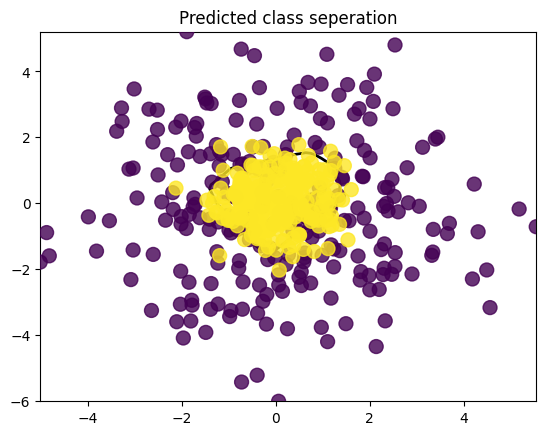

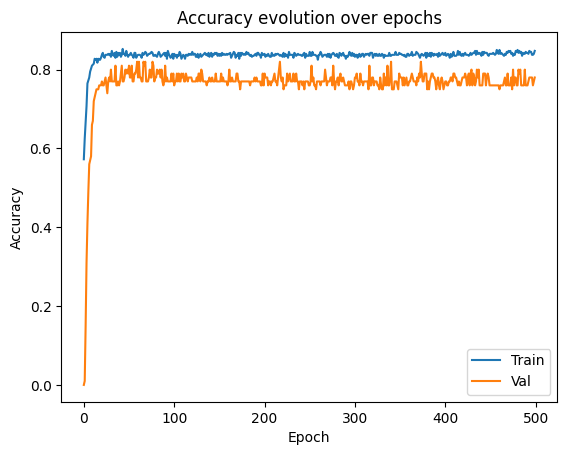

In [10]:
# Plot separating function
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

#### 2) NN with 4 hidden layer with  40 neurons

In [11]:
# Repeat the previous code but with 4 hidden layers with 40 neurons (in each layer)
model = Sequential()

start_time = time.time()

# Add layers
model.add(Dense(40, input_dim=2, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)

# Fit model
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=500,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))
print(f"\nElapsed time in seconds: {elapsed_time}")

Epoch 1/500
40/40 [==============================] - 1s 7ms/step - loss: 0.5971 - accuracy: 0.6400 - val_loss: 0.9914 - val_accuracy: 0.0000e+00
Epoch 2/500
40/40 [==============================] - 0s 3ms/step - loss: 0.5262 - accuracy: 0.6500 - val_loss: 0.8887 - val_accuracy: 0.1400
Epoch 3/500
40/40 [==============================] - 0s 3ms/step - loss: 0.4697 - accuracy: 0.7350 - val_loss: 0.7904 - val_accuracy: 0.4700
Epoch 4/500
40/40 [==============================] - 0s 3ms/step - loss: 0.4253 - accuracy: 0.7900 - val_loss: 0.6069 - val_accuracy: 0.7800
Epoch 5/500
40/40 [==============================] - 0s 3ms/step - loss: 0.4023 - accuracy: 0.8150 - val_loss: 0.6973 - val_accuracy: 0.6100
Epoch 6/500
40/40 [==============================] - 0s 4ms/step - loss: 0.3868 - accuracy: 0.8100 - val_loss: 0.5301 - val_accuracy: 0.8300
Epoch 7/500
40/40 [==============================] - 0s 3ms/step - loss: 0.3779 - accuracy: 0.8325 - val_loss: 0.5760 - val_accuracy: 0.7500
Epoch 8/5

313/313 [==============================] - 1s 2ms/step


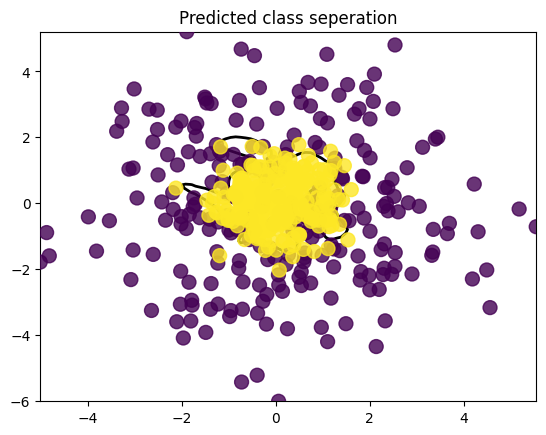

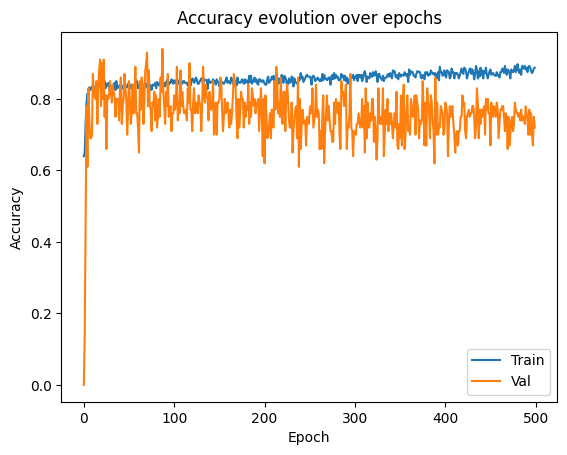

In [12]:
# Plot separating function
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

A model on a dataset not large enough with multiple hidden layers and neurons may have a higher risk of overfitting, because the dataset is not large enough. Let's try with a bigger dataset...

#### 3) Bigger Datase for both version above

In [13]:
# put your code here
Xtr, Ytr = generate_2d_cls_data(5000, 0.5)
Xte, Yte = generate_2d_cls_data(2000, 0.5)

##### Single Layer with 100 Neurons

In [14]:
# Build your first model by creating a Sequential object and then adding 2 Dense layers:
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600
400/400 [==============================] - 1s 2ms/step - loss: 0.5082 - accuracy: 0.6992 - val_loss: 0.6676 - val_accuracy: 0.6360
Epoch 2/600
400/400 [==============================] - 1s 2ms/step - loss: 0.4146 - accuracy: 0.7995 - val_loss: 0.5286 - val_accuracy: 0.7710
Epoch 3/600
400/400 [==============================] - 1s 2ms/step - loss: 0.3950 - accuracy: 0.8040 - val_loss: 0.5084 - val_accuracy: 0.7820
Epoch 4/600
400/400 [==============================] - 1s 2ms/step - loss: 0.3888 - accuracy: 0.8077 - val_loss: 0.5165 - val_accuracy: 0.7760
Epoch 5/600
400/400 [==============================] - 1s 2ms/step - loss: 0.3875 - accuracy: 0.8065 - val_loss: 0.4918 - val_accuracy: 0.7850
Epoch 6/600
400/400 [==============================] - 1s 2ms/step - loss: 0.3862 - accuracy: 0.8133 - val_loss: 0.5234 - val_accuracy: 0.7620
Epoch 7/600
400/400 [==============================] - 1s 3ms/step - loss: 0.3851 - accuracy: 0.8150 - val_loss: 0.4917 - val_accuracy: 0.7830

313/313 [==============================] - 0s 1ms/step


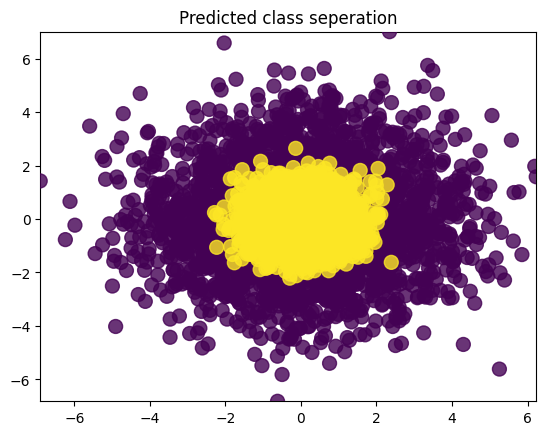

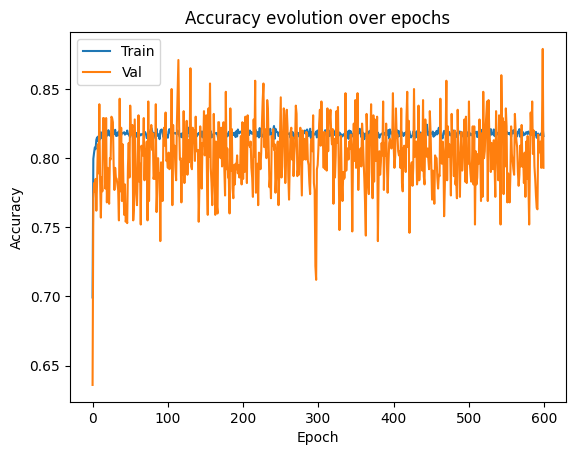

In [15]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

##### 4 Hidden Layer with 40 Neurons

In [16]:
# Repeat the previous code but with 4 hidden layers with 40 neurons (in each layer)
model = Sequential()

start_time = time.time()

# Add layers
model.add(Dense(40, input_dim=2, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)

# Fit model
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=500,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))
print(f"\nElapsed time in seconds: {elapsed_time}")

Epoch 1/500
400/400 [==============================] - 2s 3ms/step - loss: 0.4369 - accuracy: 0.7728 - val_loss: 0.4834 - val_accuracy: 0.8440
Epoch 2/500
400/400 [==============================] - 1s 2ms/step - loss: 0.3835 - accuracy: 0.8130 - val_loss: 0.4209 - val_accuracy: 0.8670
Epoch 3/500
400/400 [==============================] - 1s 2ms/step - loss: 0.3839 - accuracy: 0.8152 - val_loss: 0.4839 - val_accuracy: 0.8170
Epoch 4/500
400/400 [==============================] - 1s 2ms/step - loss: 0.3818 - accuracy: 0.8125 - val_loss: 0.3854 - val_accuracy: 0.8970
Epoch 5/500
400/400 [==============================] - 1s 3ms/step - loss: 0.3821 - accuracy: 0.8148 - val_loss: 0.4667 - val_accuracy: 0.8420
Epoch 6/500
400/400 [==============================] - 2s 4ms/step - loss: 0.3803 - accuracy: 0.8167 - val_loss: 0.3962 - val_accuracy: 0.8770
Epoch 7/500
400/400 [==============================] - 1s 4ms/step - loss: 0.3800 - accuracy: 0.8155 - val_loss: 0.4144 - val_accuracy: 0.8880

313/313 [==============================] - 1s 2ms/step


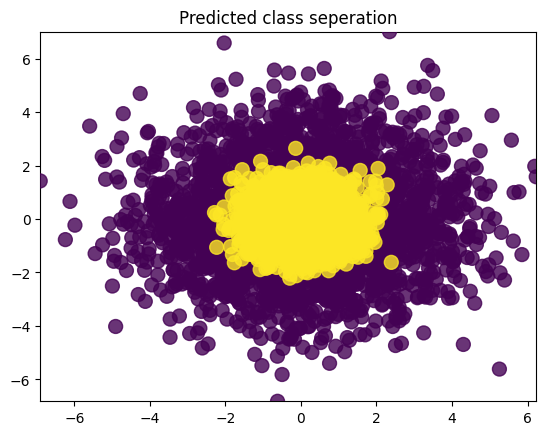

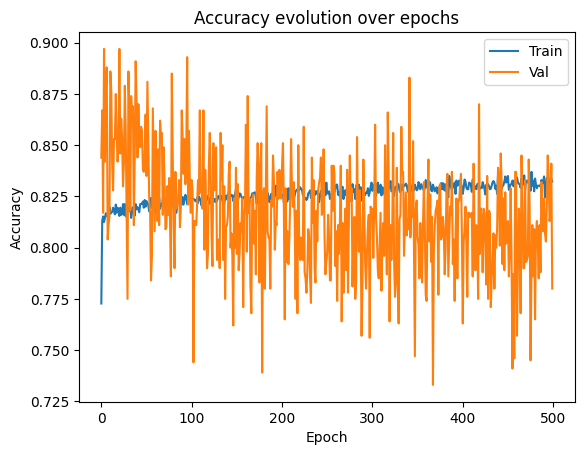

In [17]:
# Plot separating function
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

## Train a Neural Network on MNIST!

We can finally switch to a real dataset now.

First we will load the MNIST dataset and plot it to see how it really looks like.

Then we will use the notions learned in the first part to train a model which can distinguish two digits in the MNIST data.

As a bonus, some of you may want to look into multi-class classification and train a model on the whole MNIST dataset!

## Load Data

In [18]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


#### Bring the data into shape

1. Choose the digits we want to classify (variables `num_1` and `num_2`)
2. Then we restrict training and test sets to only use those numbers
3. We reshape the images from 28*28 to a single 784-dimensional vector
4. Finally we modify the labels to their appropriate range (0 and +1)

In [19]:
num_1 = 1
num_2 = 7

# Here we take only two digits from MNIST.
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]

# Reshape the data correctly
Xtr = Xtr.reshape(-1, 28*28)
Xts = Xts.reshape(-1, 28*28)
Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

We can visualize the images...

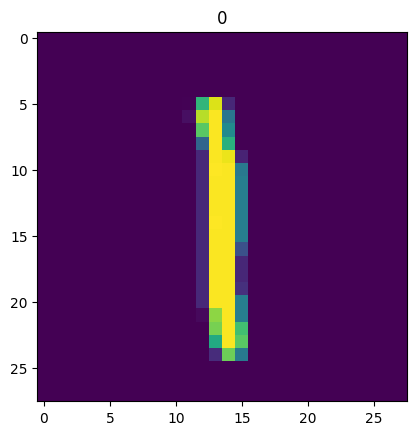

In [20]:
fig, ax = plt.subplots()
ax.imshow(Xtr[3].reshape(28, 28))
ax.set_title(Ytr[3]);

#### Define The Keras Model

In [21]:
model = Sequential()
# Add hidden layers
model.add(Dense(100, input_dim=784, activation='relu'))
# This is the last layer, it should have 1 neuron and the sigmoid activation
model.add(Dense(1, activation='sigmoid'))

#### Compile The Keras Model

Here we will use the Adam optimizer instead. It tends to work better than SGD with high dimensional data (such as our MNIST images).

In [22]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy'],)

#### Fit the model

In [23]:
# fit the keras model on the dataset
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=500,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

Epoch 1/500
1041/1041 [==============================] - 5s 3ms/step - loss: 0.8541 - accuracy: 0.9886 - val_loss: 0.2613 - val_accuracy: 0.9965
Epoch 2/500
1041/1041 [==============================] - 3s 3ms/step - loss: 0.3202 - accuracy: 0.9935 - val_loss: 0.2360 - val_accuracy: 0.9939
Epoch 3/500
1041/1041 [==============================] - 4s 4ms/step - loss: 0.1211 - accuracy: 0.9951 - val_loss: 0.0575 - val_accuracy: 0.9962
Epoch 4/500
1041/1041 [==============================] - 4s 4ms/step - loss: 0.0677 - accuracy: 0.9962 - val_loss: 0.0920 - val_accuracy: 0.9969
Epoch 5/500
1041/1041 [==============================] - 3s 3ms/step - loss: 0.0520 - accuracy: 0.9967 - val_loss: 0.0725 - val_accuracy: 0.9950
Epoch 6/500
1041/1041 [==============================] - 3s 3ms/step - loss: 0.0090 - accuracy: 0.9990 - val_loss: 0.0859 - val_accuracy: 0.9969
Epoch 7/500
1041/1041 [==============================] - 4s 4ms/step - loss: 0.0438 - accuracy: 0.9959 - val_loss: 0.0213 - val_ac

In [24]:
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

68/68 [==============================] - 0s 2ms/step
Training error: 0.04%, Test error: 0.28%


In [25]:
# evaluate the keras model. Is this consistent with the error you computed above?
_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))

68/68 [==============================] - 0s 2ms/step - loss: 0.2410 - accuracy: 0.9972
Test accuracy: 99.72%


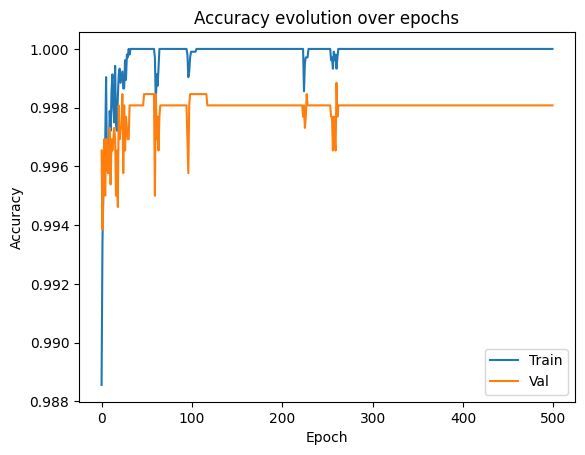

In [26]:
# Plot training history
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

## Neural Network and Convolutional Neural Network
Implement and compare a Dense neural network and a Convolutional neural network with the following architectures:

1) Neural Network architecture: 3 layers (input, output included) with 18, 8, 1 neurons.

2) Convolutional Neural Network: 2 convolutional layers with:
    - 32 filters
    - kernel size (3, 3)
    - stride: first layer= 3, second layer 2  

For both networks use SGD optimizer with learning rate 0.001, batch size of 128 and 50 epochs. Note that the number of parameters of the CNN is about 10k while the number of parameters of the dense neural network is about 12k.

Convolutional layers are implemented with the class [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

In [27]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

4422102/4422102 [==============================] - 1s 0us/step
Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


In [28]:
num_1 = 4
num_2 = 6

# Here we take only two digits from MNIST.
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1).reshape(-1) | (y_train == num_2).reshape(-1)]
Ytr = y_train[(y_train == num_1).reshape(-1) | (y_train == num_2).reshape(-1)]
Xts = x_test[(y_test == num_1).reshape(-1) | (y_test == num_2).reshape(-1)]
Yts = y_test[(y_test == num_1).reshape(-1) | (y_test == num_2).reshape(-1)]

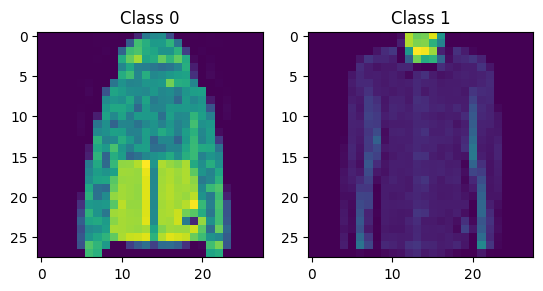

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Class 0")
ax1.imshow(Xtr[(Ytr == num_1).reshape(-1)][1])
ax2.set_title("Class 1")
ax2.imshow(Xtr[(Ytr == num_2).reshape(-1)][2])

In [30]:
batch_size= 128
epochs = 50

### **Dense network experiment**

In [54]:
# For dense network we have to transform images in vectors
Xtr = Xtr.reshape(-1, 28*28) / 255
Xts = Xts.reshape(-1, 28*28) / 255

Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

In [55]:
# Implement the dense network model
model = Sequential()

start_time = time.time()

# Add layers
model.add(Dense(8, input_dim=28*28, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation

In [56]:
# Compile the model
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.001), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)

In [57]:
# Fit the keras model on the dataset
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=epochs,                     # Number of training epochs
    batch_size=batch_size,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

Epoch 1/50
75/75 [==============================] - 1s 8ms/step - loss: 0.6834 - accuracy: 0.5775 - val_loss: 0.6586 - val_accuracy: 0.6258
Epoch 2/50
75/75 [==============================] - 0s 5ms/step - loss: 0.6534 - accuracy: 0.6294 - val_loss: 0.6443 - val_accuracy: 0.6479
Epoch 3/50
75/75 [==============================] - 0s 5ms/step - loss: 0.6401 - accuracy: 0.6636 - val_loss: 0.6316 - val_accuracy: 0.6867
Epoch 4/50
75/75 [==============================] - 0s 5ms/step - loss: 0.6271 - accuracy: 0.6893 - val_loss: 0.6195 - val_accuracy: 0.7079
Epoch 5/50
75/75 [==============================] - 0s 4ms/step - loss: 0.6143 - accuracy: 0.7135 - val_loss: 0.6079 - val_accuracy: 0.7254
Epoch 6/50
75/75 [==============================] - 0s 4ms/step - loss: 0.6021 - accuracy: 0.7307 - val_loss: 0.5960 - val_accuracy: 0.7354
Epoch 7/50
75/75 [==============================] - 0s 5ms/step - loss: 0.5901 - accuracy: 0.7458 - val_loss: 0.5846 - val_accuracy: 0.7412
Epoch 8/50
75/75 [==

In [58]:
# Evaluate the keras model
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))
print(f"\nElapsed time: {elapsed_time}")

63/63 [==============================] - 0s 2ms/step
Training error: 16.33%, Test error: 17.70%

Elapsed time: 16.842671394348145


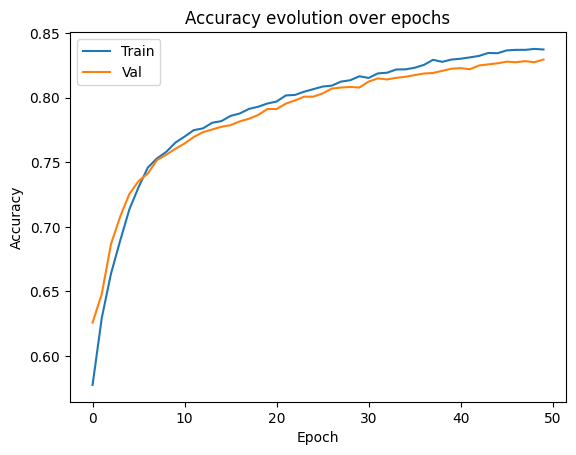

In [59]:
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

### **CNN experiment**: Repeat the previous experiment but using a CNN instead of the dense network

In [46]:
model = Sequential()

start_time = time.time()

# Add layers for CNN
#Convolutional Neural Network: 2 convolutional layers with: 32 filters, kernel size (3, 3) and stride: first layer= 3, second layer 2
model.add(Conv2D(32, kernel_size=(3, 3), strides=3, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))  # Add Pooling layer: Max Pooling with pool size (2, 2)
model.add(Conv2D(32, kernel_size=(3, 3), strides=2, activation='relu'))
model.add(MaxPool2D(pool_size=(1, 1)))  # Add Pooling layer: Max Pooling with pool size (2, 2)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation

In [47]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=['accuracy'],)

In [48]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]


Xtr = Xtr.reshape((-1, 28, 28, 1))
Xts = Xts.reshape((-1, 28, 28, 1))


Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1


In [49]:
# fit the keras model on the dataset
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=epochs,                     # Number of training epochs
    batch_size=batch_size,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

Epoch 1/50
75/75 [==============================] - 1s 11ms/step - loss: 1.8432 - accuracy: 0.6471 - val_loss: 0.6652 - val_accuracy: 0.6875
Epoch 2/50
75/75 [==============================] - 1s 9ms/step - loss: 0.5881 - accuracy: 0.7235 - val_loss: 0.5733 - val_accuracy: 0.7325
Epoch 3/50
75/75 [==============================] - 1s 9ms/step - loss: 0.5426 - accuracy: 0.7417 - val_loss: 0.5568 - val_accuracy: 0.7342
Epoch 4/50
75/75 [==============================] - 1s 9ms/step - loss: 0.5160 - accuracy: 0.7557 - val_loss: 0.5257 - val_accuracy: 0.7467
Epoch 5/50
75/75 [==============================] - 1s 9ms/step - loss: 0.4992 - accuracy: 0.7621 - val_loss: 0.5255 - val_accuracy: 0.7496
Epoch 6/50
75/75 [==============================] - 1s 9ms/step - loss: 0.4870 - accuracy: 0.7684 - val_loss: 0.5144 - val_accuracy: 0.7546
Epoch 7/50
75/75 [==============================] - 1s 10ms/step - loss: 0.4760 - accuracy: 0.7749 - val_loss: 0.5623 - val_accuracy: 0.7279
Epoch 8/50
75/75 [

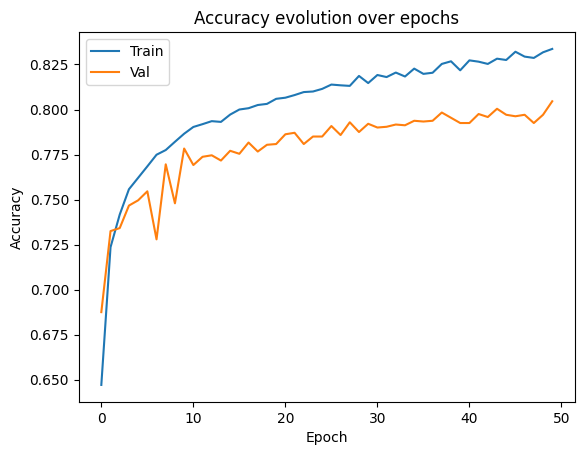

In [50]:
# Plot training history
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

In [51]:
# Evaluate the keras model
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)

# Calculate the elapsed time
elapsed_time = time.time() - start_time

print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))
print(f"\nElapsed time: {elapsed_time}")

63/63 [==============================] - 0s 2ms/step
Training error: 17.42%, Test error: 20.50%

Elapsed time: 51.63597655296326


### Plot the Neural Network structure

In [52]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_sequential_model(model):
    G = nx.Graph()

    # Add nodes
    for i, layer in enumerate(model.layers):
        layer_name = f'{layer.name}\n{layer.__class__.__name__}'
        G.add_node(layer_name)

    # Add edges
    for i in range(len(model.layers) - 1):
        source_layer = f'{model.layers[i].name}\n{model.layers[i].__class__.__name__}'
        target_layer = f'{model.layers[i+1].name}\n{model.layers[i+1].__class__.__name__}'
        G.add_edge(source_layer, target_layer)

    pos = {node: (0, -i) for i, node in enumerate(G.nodes)}

    labels = {node: node.split('\n')[0] for node in G.nodes}

    nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color="skyblue", font_size=8, font_color="black", font_weight="bold", font_family="sans-serif")
    plt.show()

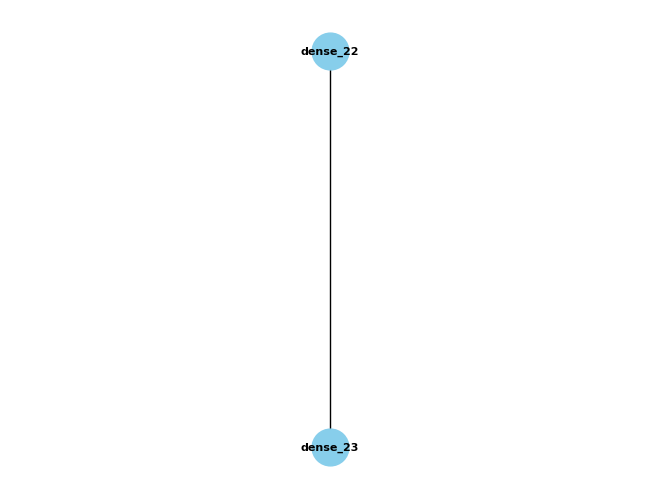

In [60]:
plot_sequential_model(model)